### Used Packeges:

In [2]:
import numpy as np
import cv2 
import pickle
import glob
import matplotlib.pyplot as plt

### Camera Calibration with OpenCV
It's recommended to use at least 20 images to get a reliable calibration. Images taken at different angles and distnaces. Each chessboard has eight by six corners to detect.  
We will map the coordinates of the corners in the 2D image (image plane) to the 3D coordinates of the real undistorted chessboard corners (objpoints).

In [3]:
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

The objectpoints will all be the same just the known objects coordinates of the chessboard cornenrs for 9 by 6 board. 

In [4]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
# objp will be the same for all the calibiration images since they
# represent a real chessboard.
objp = np.zeros((6*9,3), np.float32) 
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2) #x,y coordinates

# Make a list of calibration images
images = glob.glob('calibration_wide/GO*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners: this function returns the corners of grayscale image
    ret, corners = cv2.findChessboardCorners(gray, (8,6), None) 

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (8,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()Next, to crate the image points, i want to look at the distorted caibration image and detect the corners of the board.

In [5]:
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners: this function returns the corners of grayscale image
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None) 
    
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        write_name = 'corners_found'+str(idx)+'.jpg'
        cv2.imwrite(write_name, img)
        #cv2.imshow('img', img)
        #cv2.waitKey(500)

#cv2.destroyAllWindows()

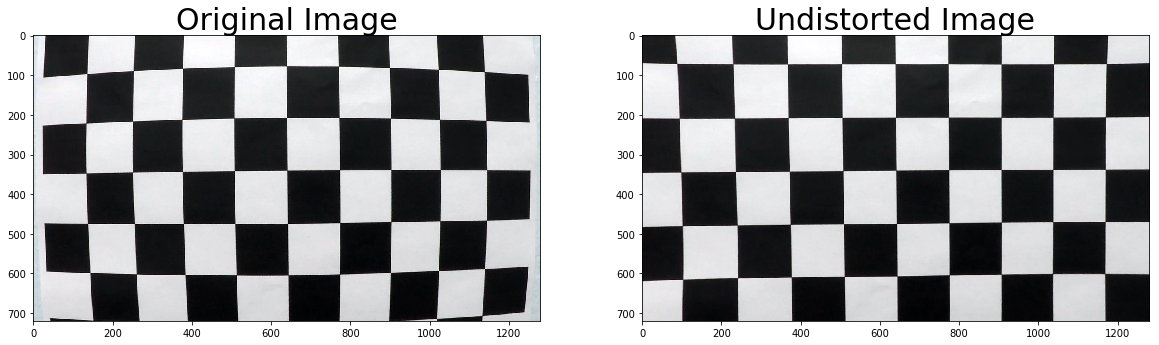

In [6]:
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('calibration_wide/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "./dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Test images:

### A simple edge detector using gradient magnitude
1. Compute gradient vector at each pixel by convolving image with horizontal and vertical derivative filters
2. Compute gradient magnitude at each pixel
3. If magnitude at a pixel exceeds a threshold, report a possible edge point

### Sobel Operator
The Sobel operator is at the heart of the Canny edge detection algorithm you used in the Introductory Lesson. Applying the Sobel operator to an image is a way of taking the derivative of the image in the x or y direction. Create a binary threshold to select pixels based on gradient strength.

### Magnitude of the Gradient
Now the goal is to apply a threshold to the overall magnitude of the gradient, in both x and y.
The magnitude, or absolute value, of the gradient is just the square root of the squares of the individual x and y gradients.

### Direction of the Gradient 
In the case of lane lines, we're interested only in edges of a particular orientation. So now we will explore the direction, or orientation, of the gradient. The direction of the gradient is simply the inverse tangent (arctangent) of the y gradient divided by the x gradient: **arctan(sobel_y/sobel_x) **

In [8]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate gradient direction
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Apply threshold
    binary_output = np.zeros_like(scaled_sobel)
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
   
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    abs_sobel = np.sqrt (sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    thresh_min = mag_thresh[0]
    thresh_max = mag_thresh[1]
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):   
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    absgraddir=np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(absgraddir)
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    binary_output[(absgraddir >= thresh_min) & (absgraddir <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

# Edit this function to create your own pipeline.
def color_threshold(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    return s_binary

## Apply a perspective transform to rectify binary image:
The first step is to determie the points

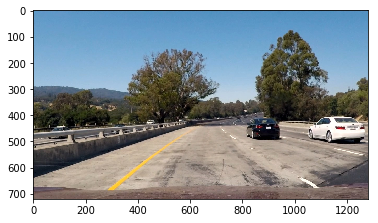

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Building a Matplotlib GUI with Qt Designer
%matplotlib qt
img = mpimg.imread('./test_images/test1.jpg')
# to  determine the stopsign four points that define a 
# rectangle on a plane in the orginal image manually.
plt.imshow(img)
plt.show()

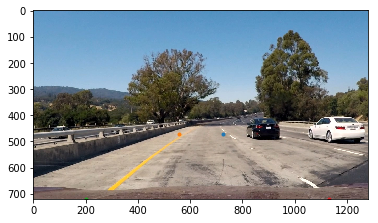

In [13]:
# plot the used points
# displa the point
%matplotlib inline
plt.imshow(img)
plt.plot(725,470,'.') # top right
plt.plot(557,470,'.') # top left
plt.plot(200,719,'.') # bottom lift
plt.plot(1130,719,'.') # bottom right
plt.show()

In [66]:

# Define calibration box in source (orginal) and desination (warped) coordinate
def M_matrix():
    # four source coordinates 
    src = np.float32(
    [[150, 719],
     [557, 470],
     [725, 470],
     [1130, 719]])

    dst = np.float32(
    [[200,720],
     [200,0],
     [1080,0],
     [1080,720]])
    
    # Compute the perspective transform, M, given source and destination points:
    M = cv2.getPerspectiveTransform(src, dst)
    # you could als get the Inverse Transform to unwarp the image
    Minv = cv2.getPerspectiveTransform(dst,src)
    return M,Minv

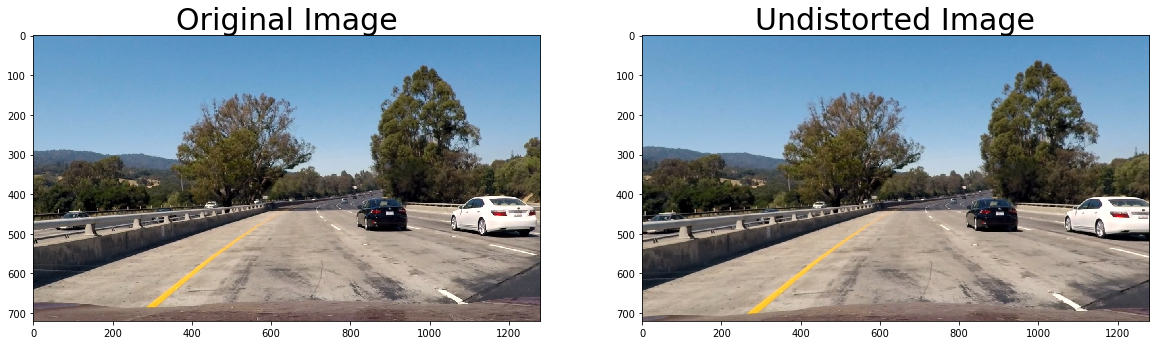

In [50]:
# load the test images
img = mpimg.imread('./test_images/test1.jpg')
undest_img = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undest_img)
ax2.set_title('Undistorted Image', fontsize=30)

(720, 1280)

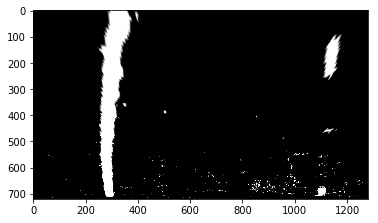

In [67]:
img = undest_img
# Apply each of the thresholding functions
gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(12, 255))
grady = abs_sobel_thresh(img, orient='y', sobel_kernel=3, thresh=(25, 255))
#mag_binary = mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255))
dir_binary = dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2))
c_binary = color_threshold(img, s_thresh=(100, 255), sx_thresh=(20, 100))
    
combined = np.zeros_like(c_binary)
combined[((gradx == 1) & (grady == 1) | (c_binary == 1) ) ] = 255
    
    
img_size = (img.shape[1],img.shape[0])
M,Minv = M_matrix()
# Warp an image using the perspective transform, M:
# flags=cv2.INTER_LINEAR is how to interpolate points which is just fillig in
# missing points (Linear Interpolation)
warped = cv2.warpPerspective(combined, M, img_size, flags=cv2.INTER_LINEAR)
    
cv2.imwrite('test_images/Ntest_'+str(idx+1)+'.jpg',warped)
plt.imshow(warped,'gray')
warped.shape

## Detect lane pixels and fit to find lane boundary

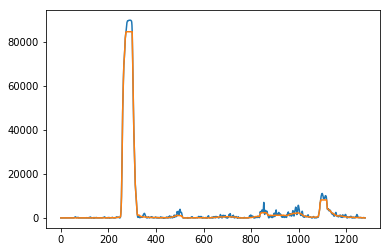

In [57]:
from scipy import signal
left_x_window_centres = []
right_x_window_centres = []
y_window_centres = []
height = warped.shape[0]
half_frame = warped.shape[1] // 2
steps = 2
pixels_per_step = height / steps
medianfilt_kernel_size = 51
histogram = np.sum(warped[int(warped.shape[0]/2):,:], axis=0)
histogram_smooth = signal.medfilt(histogram, medianfilt_kernel_size)
plt.plot(histogram)
plt.plot(histogram_smooth)

In [58]:
# Create an output image to draw on and  visualize the result
out_img = np.dstack((warped,warped, warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram_smooth.shape[0]/2)
leftx_base = np.argmax(histogram_smooth[:midpoint])
rightx_base = np.argmax(histogram_smooth[midpoint:]) + midpoint

print("Max left peak: ", leftx_base)
print("Max right peak: ", rightx_base)

Max left peak:  275
Max right peak:  1092


In [59]:
# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = warped.shape[0] - (window+1)*window_height
    win_y_high = warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

## Visualization

(720, 0)

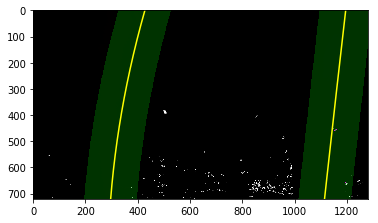

In [60]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((warped, warped,warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Measuring Curvature:

In [62]:
## Determine curvature of the lane and vehicle position with respect to center
y_eval = 500
left_curverad = np.absolute(((1 + (2 * left_fit[0] * y_eval + left_fit[1])**2) ** 1.5) \
                    /(2 * left_fit[0]))
right_curverad = np.absolute(((1 + (2 * right_fit[0] * y_eval + right_fit[1]) ** 2) ** 1.5) \
                     /(2 * right_fit[0]))
print("Left lane curve radius: ", left_curverad)
print("Right lane curve radius: ", right_curverad)
curvature = (left_curverad + right_curverad) / 2
min_curverad = min(left_curverad, right_curverad)

Left lane curve radius:  2549.62674063
Right lane curve radius:  1925.6504903


## Warp the detected lane boundaries back onto the original image.

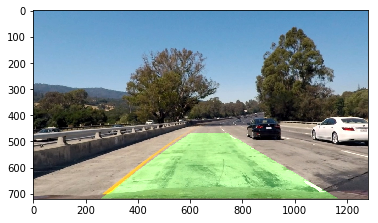

In [70]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
plt.imshow(result)